In [2]:
%autoreload 2

In [3]:
import fitsio as ft
import sys
sys.path.insert(0, '/home/mehdi/github/LSSutils')
import LSSutils.lab as lab

camb is not installed!


In [4]:
import numpy as np

def hist(data):
    kw1 = dict(range=(0.7, 3.6), bins=100, density=True)#, alpha=0.8, histtype='step')
    wt = data['WEIGHT_CP']*data['WEIGHT_FKP']*data['WEIGHT_NOZ']*data['WEIGHT_SYSTOT']        
    #for name in ['CP', 'FKP', 'NOZ', 'SYSTOT']:
    #    print(name, data[f'WEIGHT_{name}'].min(), data[f'WEIGHT_{name}'].max())
    return np.histogram(data['Z'], weights=wt, **kw1) 

In [5]:
import matplotlib.pyplot as plt

In [12]:
ls /B/Shared/eBOSS/null/EZmock_eBOSS_QSO_NGC_v7_noweight*

/B/Shared/eBOSS/null/EZmock_eBOSS_QSO_NGC_v7_noweight_0001.dat.fits*
/B/Shared/eBOSS/null/EZmock_eBOSS_QSO_NGC_v7_noweight_0001.mask.fits*
/B/Shared/eBOSS/null/EZmock_eBOSS_QSO_NGC_v7_noweight_0001.ran.fits*
/B/Shared/eBOSS/null/EZmock_eBOSS_QSO_NGC_v7_noweight_0002.dat.fits*
/B/Shared/eBOSS/null/EZmock_eBOSS_QSO_NGC_v7_noweight_0002.mask.fits*
/B/Shared/eBOSS/null/EZmock_eBOSS_QSO_NGC_v7_noweight_0002.ran.fits*
/B/Shared/eBOSS/null/EZmock_eBOSS_QSO_NGC_v7_noweight_0003.dat.fits*
/B/Shared/eBOSS/null/EZmock_eBOSS_QSO_NGC_v7_noweight_0003.mask.fits*
/B/Shared/eBOSS/null/EZmock_eBOSS_QSO_NGC_v7_noweight_0003.ran.fits*
/B/Shared/eBOSS/null/EZmock_eBOSS_QSO_NGC_v7_noweight_0004.dat.fits*
/B/Shared/eBOSS/null/EZmock_eBOSS_QSO_NGC_v7_noweight_0004.mask.fits*
/B/Shared/eBOSS/null/EZmock_eBOSS_QSO_NGC_v7_noweight_0004.ran.fits*
/B/Shared/eBOSS/null/EZmock_eBOSS_QSO_NGC_v7_noweight_0005.dat.fits*
/B/Shared/eBOSS/null/EZmock_eBOSS_QSO_NGC_v7_noweight_0005.mask.fits*
/B/Shared/eBOSS/null/EZmock_e

/home/mehdi/miniconda3/envs/py3p6/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]
/home/mehdi/miniconda3/envs/py3p6/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


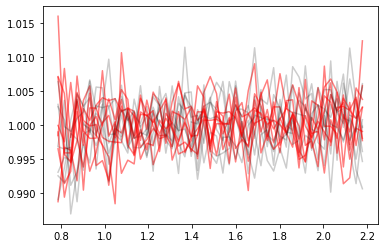

In [17]:
plt.figure()

for i in range(1, 9):
    mock = ft.read(f'/B/Shared/eBOSS/null/EZmock_eBOSS_QSO_NGC_v7_noweight_000{i}.dat.fits')
    randoms = ft.read(f'/B/Shared/eBOSS/null/EZmock_eBOSS_QSO_NGC_v7_noweight_000{i}.ran.fits')
    
    randoms_new = lab.catalogs.combinefits.reassignment(randoms, mock)
    
    hist_mock = hist(mock)
    hist_randoms = hist(randoms)
    hist_randoms_new = hist(randoms_new)
    
    plt.plot(hist_mock[1][:-1], hist_mock[0]/hist_randoms[0], 'k-', alpha=0.2)
    plt.plot(hist_mock[1][:-1], hist_mock[0]/hist_randoms_new[0], 'r-', alpha=0.5)

plt.show()    

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import nbodykit.lab as nb
import fitsio as ft
import numpy as np
import matplotlib.backends.backend_pdf

import sys
sys.path.append('/home/mehdi/github/LSSutils')
from LSSutils.io import readnbodykit

In [2]:
plt.rc('font', family='serif', size=15)

In [3]:
from glob import glob

In [54]:
def hist(data):
    kw1 = dict(range=(0.7, 3.6), bins=100, density=True)#, alpha=0.8, histtype='step')
    wt = data['WEIGHT_CP']*data['WEIGHT_FKP']*data['WEIGHT_NOZ']*data['WEIGHT_SYSTOT']        
    #for name in ['CP', 'FKP', 'NOZ', 'SYSTOT']:
    #    print(name, data[f'WEIGHT_{name}'].min(), data[f'WEIGHT_{name}'].max())
    return np.histogram(data['Z'], weights=wt, **kw1) 
    
def add_plot(ax, x, y, **kw):
    ax.step(x, y, **kw)

In [5]:
from time import time

In [55]:
cats = glob('/home/mehdi/data/eboss/mocks/null/*/EZmock_eBOSS_QSO_NGC_v7_*.dat.fits')
colors = [plt.cm.jet(i/len(cats)) for i in range(len(cats))]
print(len(cats))

t0 = time()

nl = []
xl = []
dl = []
rl = []
for i, cat in enumerate(cats):
    
    print('.', end='')
    
    if i%10==0:
        print(f'{i} in {time()-t0} sec')
        
    nl.append(cat.split('/')[-1].split('.')[0])
    
    dt_cat = ft.read(cat)
    dt_ran = ft.read(cat.replace('.dat.', '.ran.'))
    
    yd, xd = hist(dt_cat)
    yr, xr = hist(dt_ran)
    
    
    
    dl.append(yd)
    rl.append(yr)
    xl.append(xr)
    
    del dt_cat
    del dt_ran

99
.0 in 0.00039124488830566406 sec
..........10 in 20.0986750125885 sec
..........20 in 48.085577964782715 sec
..........30 in 71.63702630996704 sec
..........40 in 98.58708167076111 sec
..........50 in 123.71805310249329 sec
..........60 in 148.91202783584595 sec
..........70 in 175.2428858280182 sec
..........80 in 198.6390724182129 sec
..........90 in 225.74856233596802 sec
........

/home/mehdi/miniconda3/envs/py3p6/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/home/mehdi/miniconda3/envs/py3p6/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in less
  if __name__ == '__main__':
/home/mehdi/miniconda3/envs/py3p6/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in greater
  # Remove the CWD from sys.path while we load stuff.
No handles with labels found to put in legend.


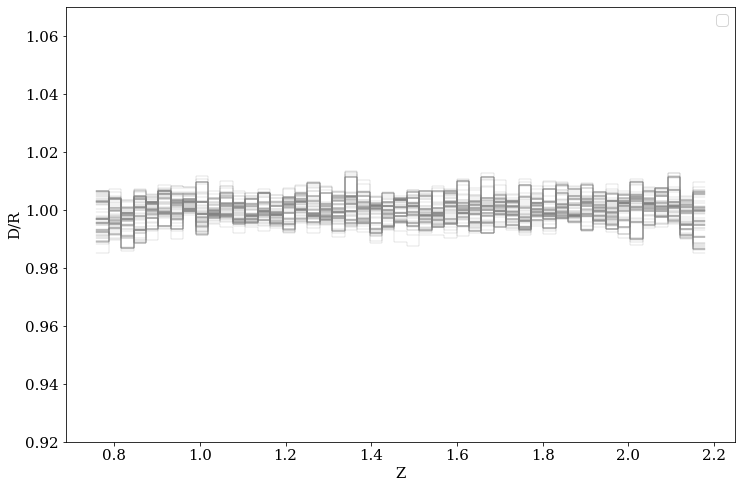

In [57]:
fig, ax = plt.subplots(figsize=(12, 8))


for i in range(len(dl)):
    #if i!=87:
    #    continue
    ratio = dl[i]/rl[i]
    
    extreme = (ratio < 0.92)
    extreme |= (ratio > 1.07)
    if extreme.sum() != 0:
        print(i, nl[i])
        ax.step(xl[0][:-1], ratio, color='r', lw=1, label=nl[i][:], zorder=100)
    ax.step(xl[0][:-1], ratio, color='grey', lw=0.2)
        
ax.set(xlabel='Z', ylabel='D/R', ylim=(0.92, 1.07))
ax.legend()

In [9]:
#fig, ax = plt.subplots(figsize=(12, 8))


for i in range(len(dl)):
    ratio = dl[i]/rl[i]
    
    extreme = (ratio < 0.92)
    extreme |= (ratio > 1.07)
    if extreme.sum() != 0:
        print(i, nl[i])
    #else:
    #    ax.step(xl[0][:-1], ratio, color=colors[i], lw=1)

#ax.set(xlabel='Z', ylabel='D/R')

87 EZmock_eBOSS_QSO_NGC_v7_wnnlowhigh_plain_0009


/home/mehdi/miniconda3/envs/py3p6/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """
/home/mehdi/miniconda3/envs/py3p6/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in less
  import sys
/home/mehdi/miniconda3/envs/py3p6/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


In [21]:
cats[87]

'/home/mehdi/data/eboss/mocks/cont/0009/EZmock_eBOSS_QSO_NGC_v7_wnnlowhigh_plain_0009.dat.fits'

In [37]:
lowhigh = glob('/home/mehdi/data/eboss/mocks/pks/pk_NGC_cont_v7_wnnlowhigh_plain_512_000*.json')

In [49]:
len(lowhigh)

9

[Text(0, 0.5, 'kP$_{\\ell}$(k)[$\\times$1e-2]'), None]

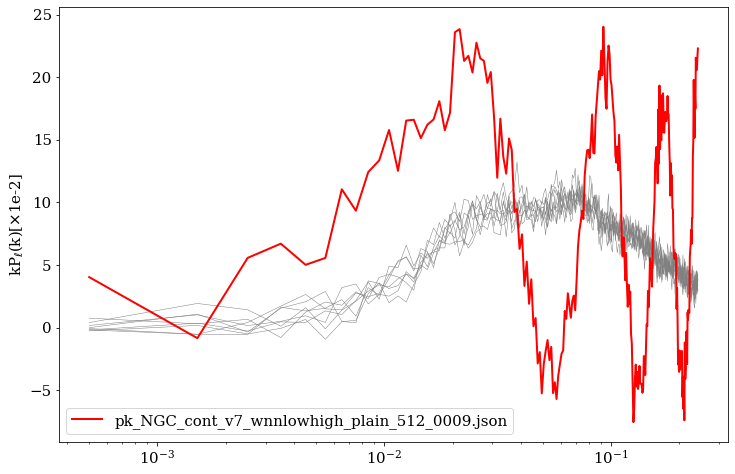

In [56]:
fig, ax = plt.subplots(figsize=(12, 8))

for i,mock in enumerate(lowhigh):
    
    d0 = nb.ConvolvedFFTPower.load(mock)
    k      = d0.poles.coords['k']
    #pk2    = (d0.poles['power_2'].real )#- d0.attrs['shotnoise'])
    pk0    = (d0.poles['power_0'].real - d0.attrs['shotnoise'])

    if np.any(k*pk0 >1500):    
        ax.plot(k, k*pk0/1.0e2, color='r', lw=2, label=mock.split('/')[-1])
    else:
        ax.plot(k, k*pk0/1.0e2, color='grey', lw=0.5)
    
ax.legend()    
ax.set(xscale='log', ylabel=r'kP$_{\ell}$(k)[$\times$1e-2]')

In [25]:
dt_cat = ft.read(cats[80])
dt_ran = ft.read(cats[80].replace('.dat.', '.ran.'))
for dt_i in [dt_cat, dt_ran]:
    for name in ['CP', 'FKP', 'NOZ', 'SYSTOT']:
        print(name, dt_i[f'WEIGHT_{name}'].min(), dt_i[f'WEIGHT_{name}'].max())

CP 1.0 4.0
FKP 0.8203800320041643 0.9083700405956174
NOZ 0.0 1.0934798374736978
SYSTOT 0.6852076226794422 1.5434512453519393
CP 1.0 4.0
FKP 0.8203800320041643 0.9083700405956174
NOZ 0.0 1.0934798374736978
SYSTOT 0.4433198728065339 1.5434512453519393


87 EZmock_eBOSS_QSO_NGC_v7_wnnlowhigh_plain_0009


/home/mehdi/miniconda3/envs/py3p6/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/home/mehdi/miniconda3/envs/py3p6/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in less
  if __name__ == '__main__':
/home/mehdi/miniconda3/envs/py3p6/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in greater
  # Remove the CWD from sys.path while we load stuff.


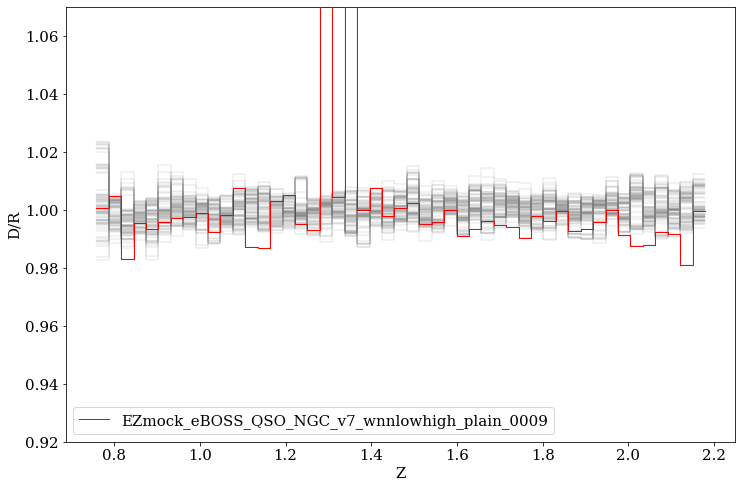

In [47]:
fig, ax = plt.subplots(figsize=(12, 8))


for i in range(len(dl)):
    #if i!=87:
    #    continue
    ratio = dl[i]/rl[i]
    
    extreme = (ratio < 0.92)
    extreme |= (ratio > 1.07)
    if extreme.sum() != 0:
        print(i, nl[i])
        ax.step(xl[0][:-1], ratio, color='r', lw=1, label=nl[i][:], zorder=100)
    ax.step(xl[0][:-1], ratio, color='grey', lw=0.2)
        
ax.set(xlabel='Z', ylabel='D/R', ylim=(0.92, 1.07))
ax.legend()

In [ ]:
for i in range(2):
    print(i)
    add_plot(xd[:-1], yd/yr, ls='--', lw=2, color=colors[i])
plt.ylim(0.92, 1.07)    
#     add_plot(xl[i][:-1], dl[i]/rl[i], 
#              ls='--', lw=2, color=colors[i])

# # hist(random,  label='random', ls='--')
# # hist(random2, label='random (bad reassignment)', ls=':')
# # hist(random1, label='random (bad systot, bad reassignment)', ls='-.')
# plt.legend(bbox_to_anchor=(1.1, 1))
# plt.ylim(0.92, 1.07)
# plt.xlabel('Z')

In [ ]:
mock = ft.read('/home/mehdi/data/eboss/mocks/')

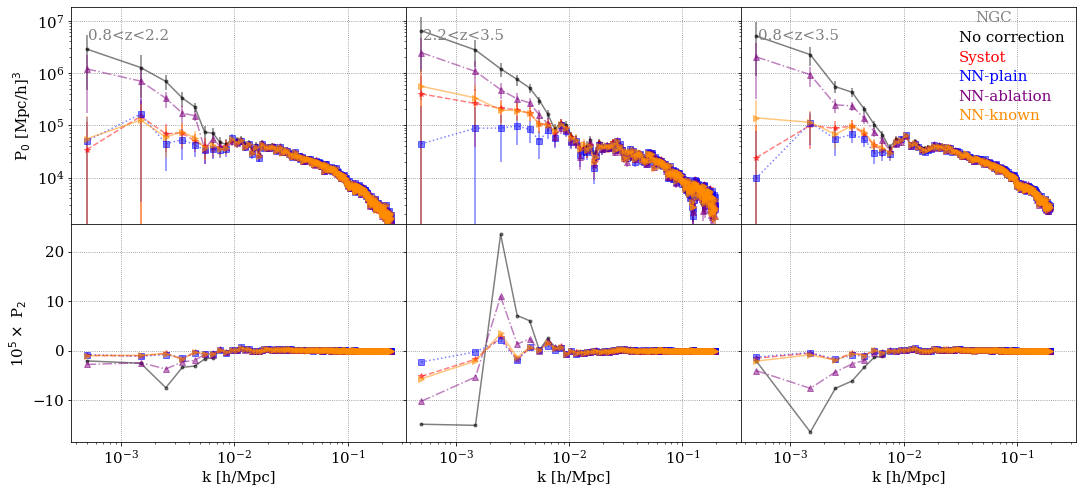

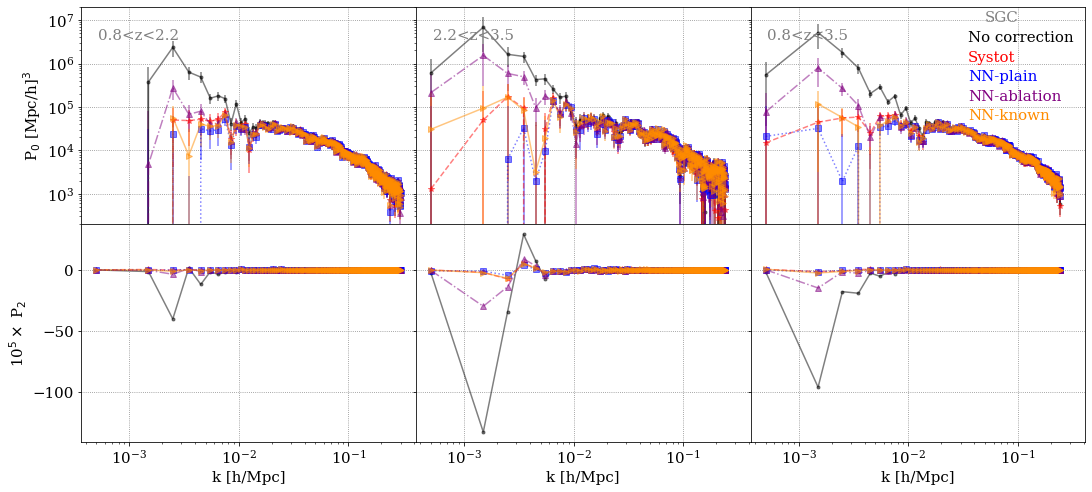

In [5]:
pdfname = 'eboss_qso_v7_2_0.2.pdf'

caps = ['NGC', 'SGC']
samples = ['standard', 'zhigh', 'combined']
treatments = ['No correction', 'Systot',   'NN-plain', 'NN-ablation', 'NN-known']
models  = ['wosystot', 'wsystot',  'plain_lowmidhigh', 'ablation_lowmidhigh', 'known_lowmidhigh']

mk = ['.', '*', 's', '^', '>', 'o']
c = ['k', 'r', 'b', 'purple', 'darkorange']
ls = 2*['-', '--', ':', '-.']
path = '/home/mehdi/data/eboss/v7_2/0.2/'
pkout = lambda cap, model, sample : f'pk_{cap}_v7_2_0.2_{model}_512_{sample}.txt'
labels = {'standard':'0.8<z<2.2',
           'zhigh':'2.2<z<3.5',
          'combined':'0.8<z<3.5'} 



#pdf = matplotlib.backends.backend_pdf.PdfPages(pdfname) 

pdf_i = 0
for cap in caps:    
    fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(18, 8), 
                           sharey='row', sharex=True)
    ax = ax.flatten()
    fig.subplots_adjust(wspace=0.0, hspace=0.0)

    for j, sample in enumerate(samples):

        for i,model in enumerate(models):

            pk_i, shotnoise = readnbodykit(path + pkout(cap, model, sample))
            
            err = pk_i[:,2]/(0.5*pk_i[:,5])**0.5
            
            # monopole
            ax[j].errorbar(pk_i[:,0], pk_i[:,2]-shotnoise,
                           yerr=err,
                           label=treatments[i], ls=ls[i], c=c[i], marker=mk[i])
            
            # quadrupole
            ax[j+3].errorbar(pk_i[:,0], pk_i[:,3]/1e5,
                           label=treatments[i], ls=ls[i], c=c[i], marker=mk[i])

    ##-- cosmetics
    # redshifts
    for i, sample in enumerate(samples):
        ax[i].text(0.05, 0.85, 
                   labels[sample], 
                   color='grey',
                   transform=ax[i].transAxes)

        
        
        
    # labels
    ax[2].text(0.7, 0.93, cap.upper(), color='grey', transform=ax[2].transAxes)
    for i in range(len(models)):
        j == 2 # top right
        ax[j].text(0.65, 0.84-i*0.09, 
                   treatments[i], 
                   color=c[i], 
                   transform=ax[j].transAxes)
    
    # x-y axes labels
    for i, axi in enumerate(ax):
        axi.set(xscale='log')
        axi.grid(True, ls=':', color='grey')
        if i<3:
            #axi.set_yscale('log')
            if i==0:
                axi.set_ylabel(r'P$_{0}$ [Mpc/h]$^{3}$')
        else:
            axi.set(xlabel='k [h/Mpc]')
            if i==3:
                axi.set_ylabel(r'10$^{-5}\times$ P$_{2}$')
    #pdf.savefig((pdf_i+1), bbox_inches='tight')
    #pdf_i += 1
#pdf.close()  

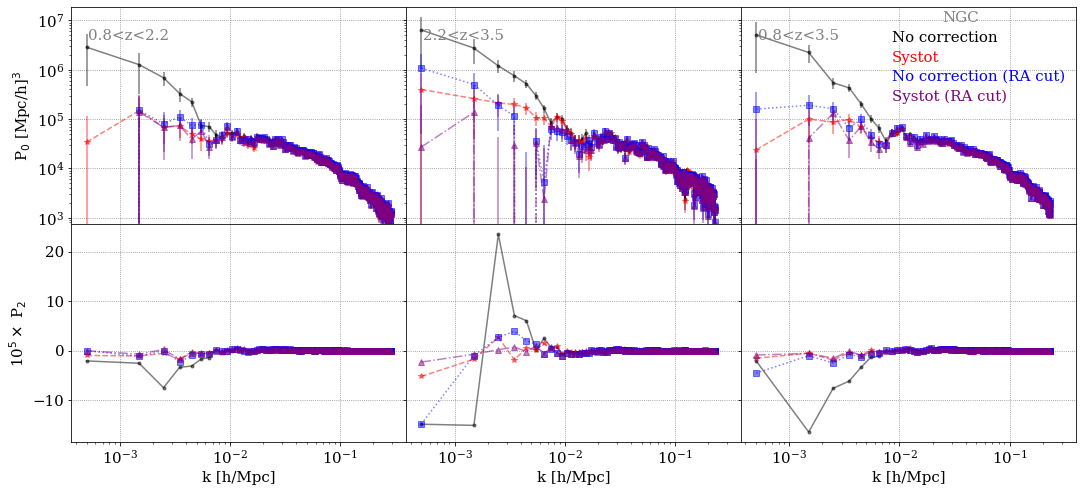

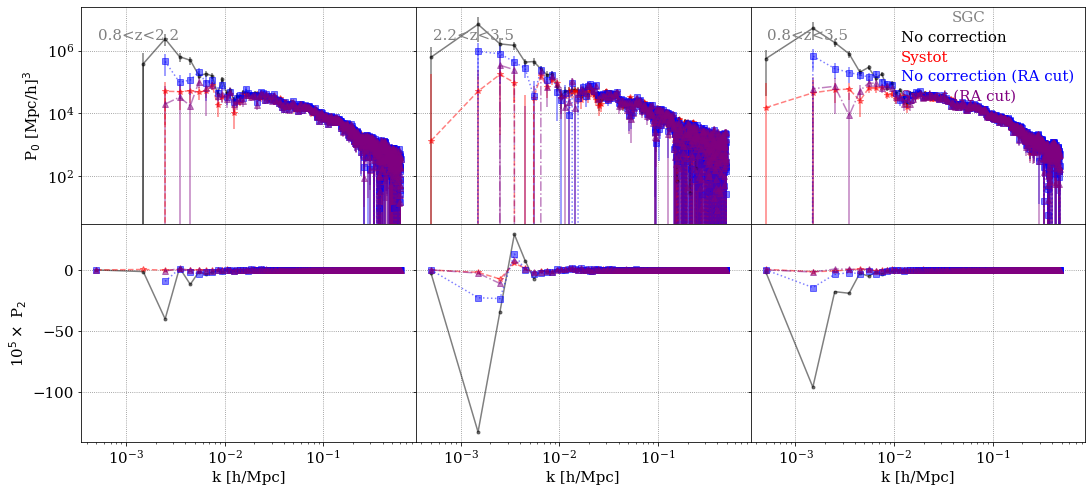

In [10]:
#pdfname = 'eboss_qso_v7_2_0.2_ra_cut.pdf'

caps = ['NGC', 'SGC']
samples = ['standard', 'zhigh', 'combined']
treatments = ['No correction', 'Systot', 'No correction (RA cut)', 'Systot (RA cut)']
models  = ['wosystot', 'wsystot',  'wosystot_racut', 'wsystot_racut']
#treatments = ['No correction (RA cut)', 'Systot (RA cut)']
#models  = ['wosystot_racut', 'wsystot_racut']

mk = ['.', '*', 's', '^', '>', 'o']
c = ['k', 'r', 'b', 'purple', 'darkorange']
ls = 2*['-', '--', ':', '-.']
path = '/home/mehdi/data/eboss/v7_2/0.2/'
pkout = lambda cap, model, sample : f'pk_{cap}_v7_2_0.2_{model}_512_{sample}.txt'
labels = {'standard':'0.8<z<2.2',
           'zhigh':'2.2<z<3.5',
          'combined':'0.8<z<3.5'} 



#pdf = matplotlib.backends.backend_pdf.PdfPages(pdfname) 
#pdf_i = 0

for cap in caps:    
    fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(18, 8), 
                           sharey='row', sharex=True)
    ax = ax.flatten()
    fig.subplots_adjust(wspace=0.0, hspace=0.0)

    for j, sample in enumerate(samples):

        for i,model in enumerate(models):

            pk_i, shotnoise = readnbodykit(path + pkout(cap, model, sample))
            
            err = pk_i[:,2]/(0.5*pk_i[:,5])**0.5
            
            # monopole
            ax[j].errorbar(pk_i[:,0], pk_i[:,2]-shotnoise,
                           yerr=err,
                           label=treatments[i], ls=ls[i], c=c[i], marker=mk[i], alpha=0.5)
            
            # quadrupole
            ax[j+3].errorbar(pk_i[:,0], pk_i[:,3]/1e5,
                           label=treatments[i], ls=ls[i], c=c[i], marker=mk[i], alpha=0.5)

    ##-- cosmetics
    # redshifts
    for i, sample in enumerate(samples):
        ax[i].text(0.05, 0.85, 
                   labels[sample], 
                   color='grey',
                   transform=ax[i].transAxes)

        
        
        
    # labels
    ax[2].text(0.6, 0.93, cap.upper(), color='grey', transform=ax[2].transAxes)
    for i in range(len(models)):
        j == 2 # top right
        ax[j].text(0.45, 0.84-i*0.09, 
                   treatments[i], 
                   color=c[i], 
                   transform=ax[j].transAxes)
    
    # x-y axes labels
    for i, axi in enumerate(ax):
        axi.set(xscale='log')
        axi.grid(True, ls=':', color='grey')
        if i<3:
            axi.set_yscale('log')
            #axi.set_ylim(ymax=5e5)
            if i==0:
                axi.set_ylabel(r'P$_{0}$ [Mpc/h]$^{3}$')
        else:
            axi.set(xlabel='k [h/Mpc]')
            if i==3:
                axi.set_ylabel(r'10$^{-5}\times$ P$_{2}$')
    #pdf.savefig((pdf_i+1), bbox_inches='tight')
    #pdf_i += 1
#pdf.close()  

In [3]:
ls -lt /home/mehdi/data/eboss/v7_2/0.2/pk*.txt

-rw-r--r-- 1 mehdi users 22302 Mar 10 14:04 /home/mehdi/data/eboss/v7_2/0.2/pk_SGC_v7_2_0.2_wosystot_512_zextend3.0.txt
-rw-r--r-- 1 mehdi users 22461 Mar 10 14:04 /home/mehdi/data/eboss/v7_2/0.2/pk_SGC_v7_2_0.2_wsystot_512_zextend3.0.txt
-rw-r--r-- 1 mehdi users 18166 Mar 10 14:03 /home/mehdi/data/eboss/v7_2/0.2/pk_NGC_v7_2_0.2_wosystot_512_zextend3.0.txt
-rw-r--r-- 1 mehdi users 18234 Mar 10 14:02 /home/mehdi/data/eboss/v7_2/0.2/pk_NGC_v7_2_0.2_wsystot_512_zextend3.0.txt
-rw-r--r-- 1 mehdi users 23083 Mar 10 14:01 /home/mehdi/data/eboss/v7_2/0.2/pk_SGC_v7_2_0.2_wosystot_512_zextend2.8.txt
-rw-r--r-- 1 mehdi users 23063 Mar 10 14:01 /home/mehdi/data/eboss/v7_2/0.2/pk_SGC_v7_2_0.2_wsystot_512_zextend2.8.txt
-rw-r--r-- 1 mehdi users 18725 Mar 10 14:00 /home/mehdi/data/eboss/v7_2/0.2/pk_NGC_v7_2_0.2_wosystot_512_zextend2.8.txt
-rw-r--r-- 1 mehdi users 18784 Mar 10 13:59 /home/mehdi/data/eboss/v7_2/0.2/pk_NGC_v7_2_0.2_wsystot_512_zextend2.8.txt
-rw-r--r-- 1 mehdi users 23790 Mar 10 13:58 

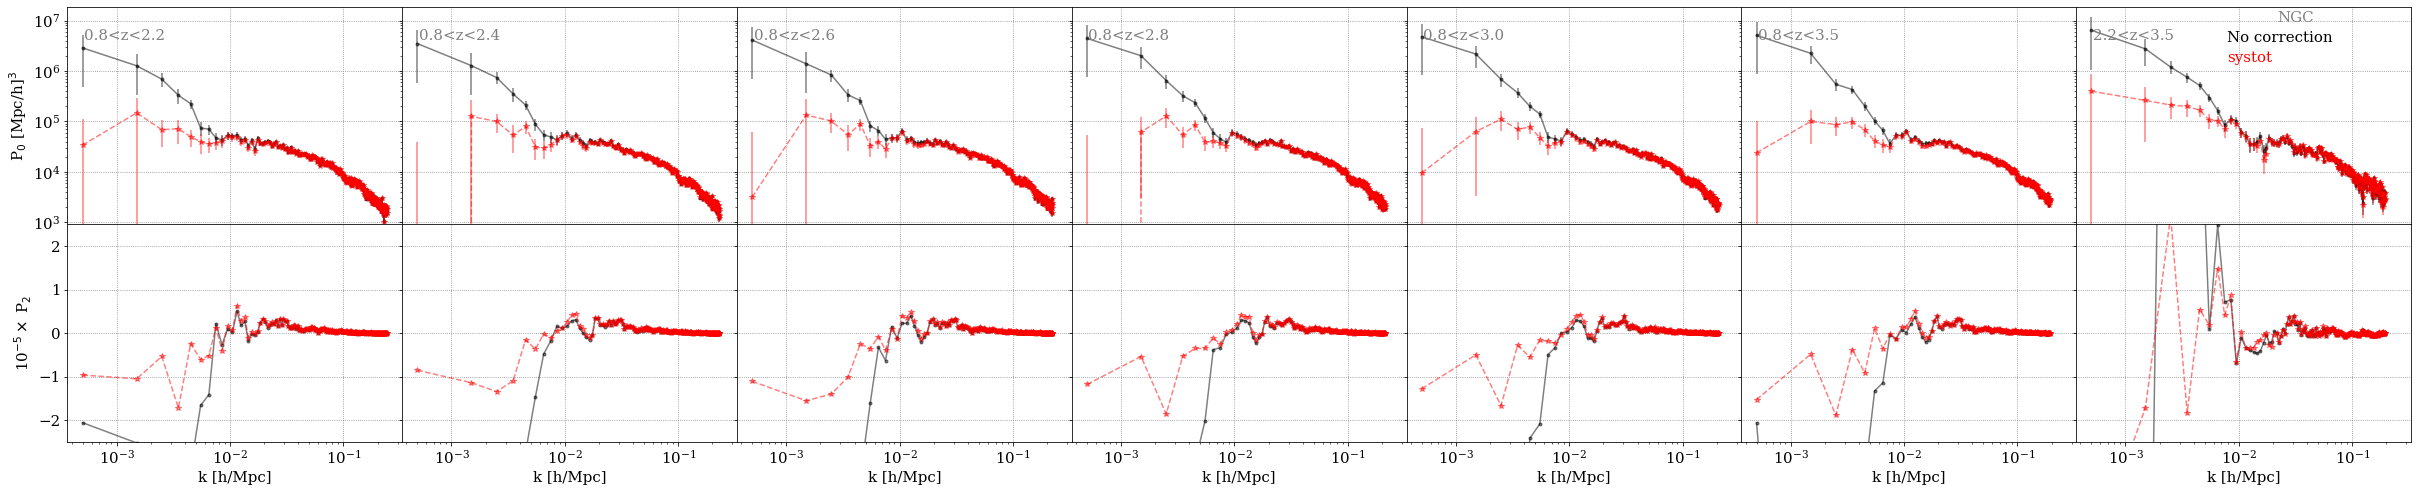

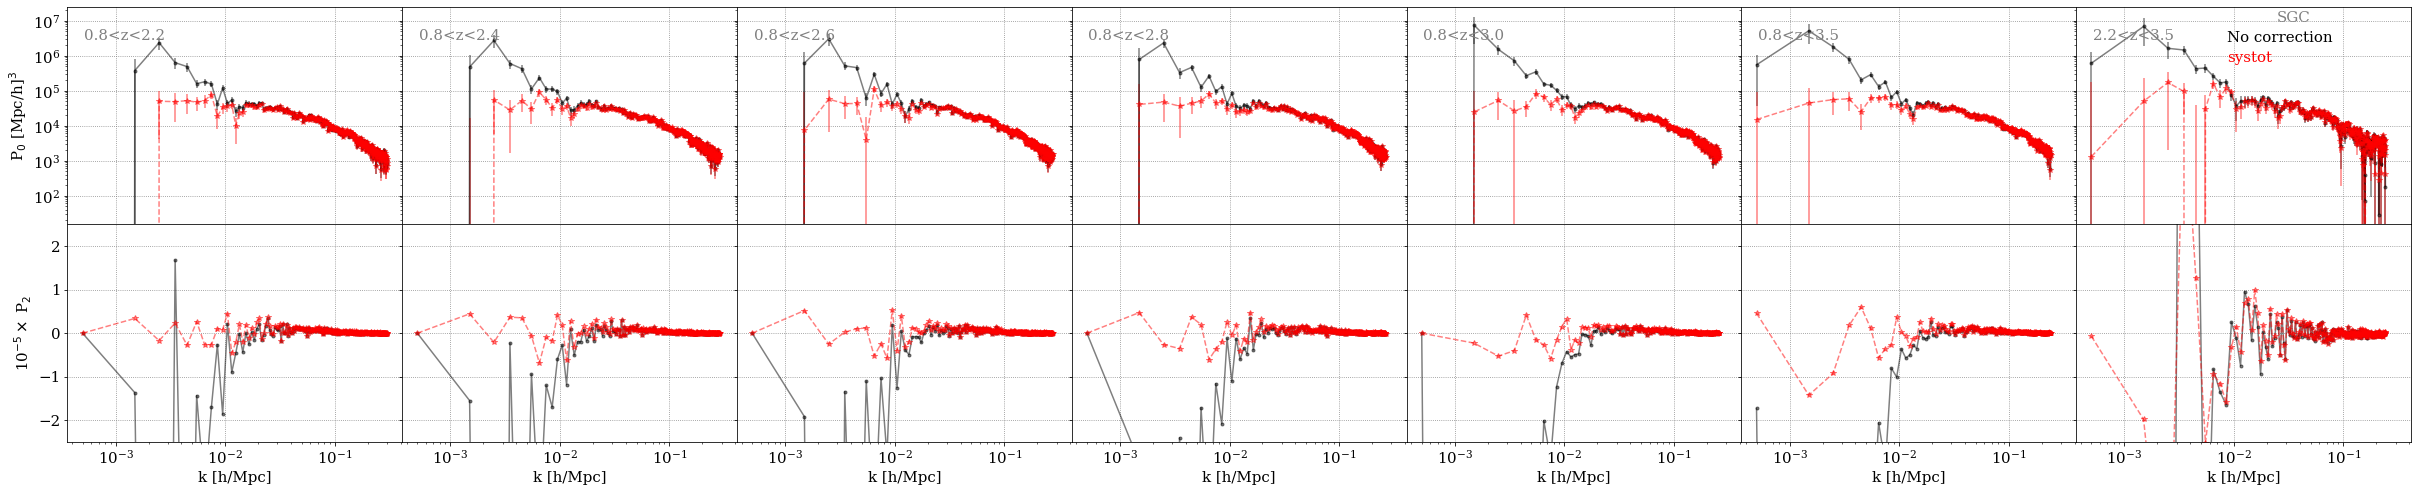

In [77]:
pdfname = 'eboss_qso_v7_2_0.2_zmax.pdf'

caps = ['NGC', 'SGC']
samples = ['standard', 'zextend2.4', 'zextend2.6', 'zextend2.8', 'zextend3.0', 'combined', 'zhigh']
treatments = ['No correction', 'systot']
models  = ['wosystot', 'wsystot']
#treatments = ['No correction (RA cut)', 'Systot (RA cut)']
#models  = ['wosystot_racut', 'wsystot_racut']

mk = ['.', '*', 's', '^', '>', 'o']
c = ['k', 'r', 'b', 'purple', 'darkorange']
ls = 2*['-', '--', ':', '-.']
path = '/home/mehdi/data/eboss/v7_2/0.2/'
pkout = lambda cap, model, sample : f'pk_{cap}_v7_2_0.2_{model}_512_{sample}.txt'
labels = {'standard':'0.8<z<2.2',
           'zextend2.4':'0.8<z<2.4',
          'zextend2.6':'0.8<z<2.6',
          'zextend2.8':'0.8<z<2.8',
          'zextend3.0':'0.8<z<3.0',
          'combined':'0.8<z<3.5',
         'zhigh':'2.2<z<3.5'} 



#pdf = matplotlib.backends.backend_pdf.PdfPages(pdfname) 
#pdf_i = 0

ncols=7
for cap in caps:    
    fig, ax = plt.subplots(ncols=ncols, nrows=2, figsize=(6*ncols, 8), 
                           sharey='row', sharex=True)
    ax = ax.flatten()
    fig.subplots_adjust(wspace=0.0, hspace=0.0)

    for j, sample in enumerate(samples):

        for i,model in enumerate(models):

            pk_i, shotnoise = readnbodykit(path + pkout(cap, model, sample))
            
            err = pk_i[:,2]/(0.5*pk_i[:,5])**0.5
            
            # monopole
            ax[j].errorbar(pk_i[:,0], pk_i[:,2]-shotnoise,
                           yerr=err,
                           label=treatments[i], ls=ls[i], c=c[i], marker=mk[i], alpha=0.5)
            
            # quadrupole
            ax[j+ncols].errorbar(pk_i[:,0], pk_i[:,3]/1e5,
                           label=treatments[i], ls=ls[i], c=c[i], marker=mk[i], alpha=0.5)

    ##-- cosmetics
    # redshifts
    for i, sample in enumerate(samples):
        ax[i].text(0.05, 0.85, 
                   labels[sample], 
                   color='grey',
                   transform=ax[i].transAxes)

        
        
        
    # labels
    ax[ncols-1].text(0.6, 0.93, cap.upper(), color='grey', transform=ax[ncols-1].transAxes)
    for i in range(len(models)):
        j == ncols-1 # top right
        ax[j].text(0.45, 0.84-i*0.09, 
                   treatments[i], 
                   color=c[i], 
                   transform=ax[j].transAxes)
    
    # x-y axes labels
    for i, axi in enumerate(ax):
        axi.set(xscale='log')
        axi.grid(True, ls=':', color='grey')
        if i<ncols:
            axi.set_yscale('log')
            #axi.set_ylim(ymax=5e5)
            if i==0:
                axi.set_ylabel(r'P$_{0}$ [Mpc/h]$^{3}$')
        else:
            axi.set(xlabel='k [h/Mpc]', ylim=(-2.5, 2.5))
            if i==ncols:
                axi.set_ylabel(r'10$^{-5}\times$ P$_{2}$')
    #pdf.savefig((pdf_i+1), bbox_inches='tight')
    #pdf_i += 1
#pdf.close()  

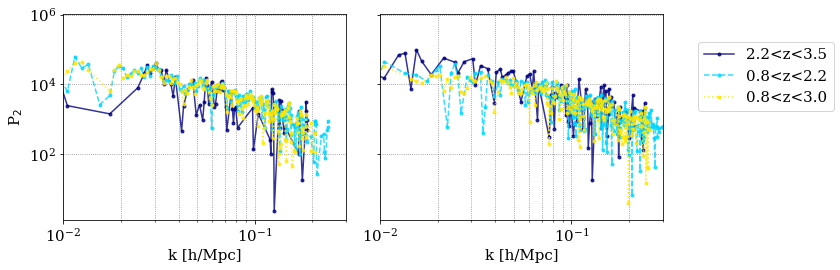

In [75]:


caps = ['NGC', 'SGC']
samples = ['zhigh', 'standard', 'zextend3.0']#, 'zextend2.4', 'zextend2.6', 'zextend2.8',  'combined']
treatments = ['systot']
models  = ['wsystot']

mk = ['.', '*', 's', '^', '>', 'o']
c = [plt.cm.jet(i/len(samples)) for i in range(len(samples))]
ls = 2*['-', '--', ':', '-.']
path = '/home/mehdi/data/eboss/v7_2/0.2/'
pkout = lambda cap, model, sample : f'pk_{cap}_v7_2_0.2_{model}_512_{sample}.txt'
labels = {'zhigh':'2.2<z<3.5',
          'standard':'0.8<z<2.2',
          'zextend2.4':'0.8<z<2.4',
          'zextend2.6':'0.8<z<2.6',
          'zextend2.8':'0.8<z<2.8',
          'zextend3.0':'0.8<z<3.0',
          'combined':'0.8<z<3.5'} 

ncols=2
fig, ax = plt.subplots(ncols=ncols, figsize=(6*ncols, 4), 
                       sharey='row', sharex=True)
ax = ax.flatten()
fig.subplots_adjust(wspace=0.0, hspace=0.0)

for k,cap in enumerate(caps):    

    for j, sample in enumerate(samples):

        for i,model in enumerate(models):

            pk_i, shotnoise = readnbodykit(path + pkout(cap, model, sample))
            
            # quadrupole
            positive = pk_i[:,3]>0
            ax[k].errorbar(pk_i[positive,0], pk_i[positive,3],
                           label=labels[sample], ls=ls[j], c=c[j], marker='.', alpha=0.8)
    ax[k].set_yscale('log')
    ax[k].set(xscale='log', xlabel='k [h/Mpc]', xlim=(0.01, 0.3))#, ylim=(-1.0e4, 8.0e4))
    ax[k].grid(True, ls=':', color='grey', which='both')
    if k==1:
        ax[k].legend(bbox_to_anchor=(1.1, .9))
    else:
        ax[k].set_ylabel(r'P$_{2}$')
fig.tight_layout()

In [3]:
data = ft.read('/home/mehdi/data/eboss/v7_2/0.1/eBOSS_QSO_clustering_NGC_v7_2_0.1.dat.fits')
random = ft.read('/home/mehdi/data/eboss/v7_2/0.1/eBOSS_QSO_clustering_NGC_v7_2_0.1.ran.fits')
random1 = ft.read('/home/mehdi/data/eboss/v7_2/0.1/eBOSS_QSO_clustering_NGC_v7_2_0.1_old.ran.fits')
random2 = ft.read('/home/mehdi/data/eboss/v7_2/0.1/eBOSS_QSO_clustering_NGC_v7_2_0.1_old2.ran.fits')

/home/mehdi/miniconda3/envs/py3p6/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.
/home/mehdi/miniconda3/envs/py3p6/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  
/home/mehdi/miniconda3/envs/py3p6/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


Text(0.5, 0, 'Z')

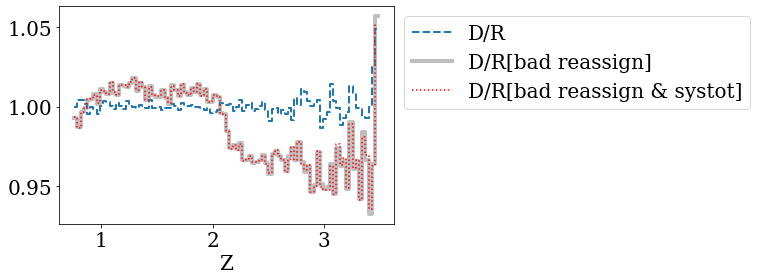

In [5]:
def hist(data):
    kw1 = dict(range=(0.7, 3.6), bins=100, density=True)#, alpha=0.8, histtype='step')
    wt = data['WEIGHT_CP']*data['WEIGHT_FKP']*data['WEIGHT_NOZ']*data['WEIGHT_SYSTOT']
    return np.histogram(data['Z'], weights=wt, **kw1) 
    
def add_plot(x, y, **kw):
    plt.step(x, y, **kw)
    
    
    
yd, xd = hist(data)
yr, xr = hist(random)
yr2, xr2 = hist(random2)
yr1, xr1 = hist(random1)



add_plot(xd[:-1], yd/yr, label='D/R', ls='--', lw=2)
add_plot(xd[:-1], yd/yr2, label='D/R[bad reassign]', ls='-', lw=4, color='grey', alpha=0.5)
add_plot(xd[:-1], yd/yr1, label='D/R[bad reassign & systot]', ls=':', color='r')

# hist(random,  label='random', ls='--')
# hist(random2, label='random (bad reassignment)', ls=':')
# hist(random1, label='random (bad systot, bad reassignment)', ls='-.')
plt.legend(bbox_to_anchor=(1., 1))
plt.xlabel('Z')

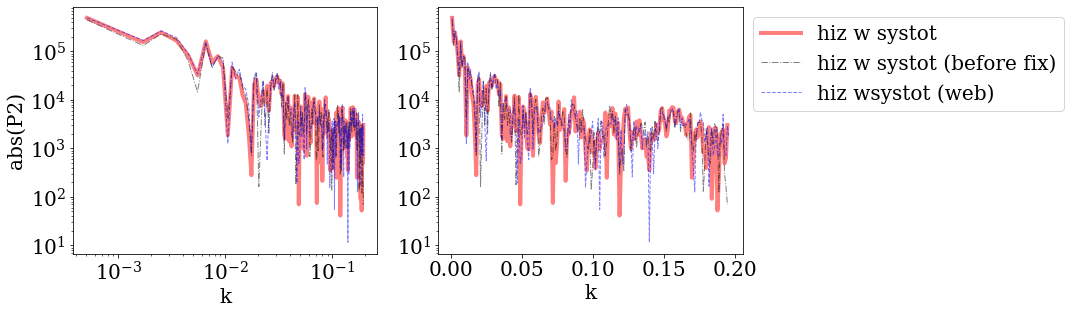

In [28]:
c = ['r', 'k', 'b']
ls = ['-', '-.', '--']
lw = [4, 1, 1]
t = ['hiz w systot', 'hiz w systot (before fix)', 'hiz wsystot (web)']
plt.figure(figsize=(12, 10))
for j in range(2):
    plt.subplot(221+j)
    for i,psys_i in enumerate([psys, psysw, psysw0]):
        plt.plot(psys_i.poles['k'], abs(psys_i.poles['power_2'].real), 
                 color=c[i], label=t[i], alpha=0.5, ls=ls[i], lw=lw[i])
        #plt.plot(psys_i.poles['k'], -psys_i.poles['power_2'].real, ls='--', color=c[i], alpha=0.5)

    plt.xlabel('k')

    if j==0:
        plt.ylabel('abs(P2)')
        plt.yscale('log')
        plt.xscale('log')
        
    if j==1:
        plt.yscale('log')
        plt.legend(bbox_to_anchor=(1.,1))


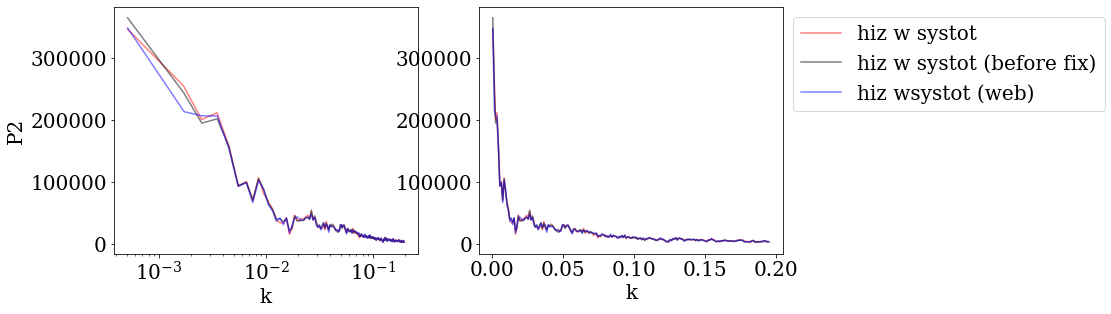

In [32]:
c = ['r', 'k', 'b']
ls = ['-', '-.', '--']
lw = [4, 1, 1]
t = ['hiz w systot', 'hiz w systot (before fix)', 'hiz wsystot (web)']
plt.figure(figsize=(12, 10))
for j in range(2):
    plt.subplot(221+j)
    for i,psys_i in enumerate([psys, psysw, psysw0]):
        plt.plot(psys_i.poles['k'], psys_i.poles['power_0'].real-psys_i.attrs['shotnoise'], 
                 color=c[i], label=t[i], alpha=0.5)
        #plt.plot(psys_i.poles['k'], -psys_i.poles['power_2'].real, ls='--', color=c[i], alpha=0.5)

    plt.xlabel('k')

    if j==0:
        plt.ylabel('P2')
        #plt.yscale('log')
        plt.xscale('log')
        
    if j==1:
        #plt.yscale('log')
        plt.legend(bbox_to_anchor=(1.,1))



In [10]:
def test_cats(cap, tag='', passfix='ran'):
    # -- read
    randomw = ft.read(f'/home/mehdi/data/eboss/v7_2/eBOSS_QSOandhiz_clustering_{cap}_v7_2.{passfix}.fits')
    random = ft.read(f'/home/mehdi/data/eboss/v7_2/0.1/eBOSS_QSO_clustering_{cap}_v7_2_0.1{tag}.{passfix}.fits')

    # Q1: any different columns?

    for colname in randomw.dtype.names:
        diff = np.setdiff1d(random[colname], randomw[colname])
        if not np.array_equal(diff, []):
            print(f'{colname} has {len(diff)}')


    # Z and Weight_Systot are different
    # Q2: what is the distribution of these two?

    fig, ax = plt.subplots(ncols=2, figsize=(12, 4))
    c = ['k', 'r']

    for i, (n,r) in enumerate(zip(['full', 'web'], [random, randomw])):

        print('wsys:', np.percentile(r['WEIGHT_SYSTOT'], [0, 50, 100]))
        print('z:   ',  np.percentile(r['Z'], [0, 50, 100]))

        ax[0].hist(r['WEIGHT_SYSTOT'], range=(0.4, 2.0), bins=32, color=c[i], histtype='step')
        ax[1].hist(r['Z'], range=(0.8, 3.5), bins=54, color=c[i], histtype='step', 
                   weights=r['WEIGHT_CP']*r['WEIGHT_FKP']*r['WEIGHT_NOZ']*r['WEIGHT_SYSTOT'],
                   density=True)

        ax[0].text(0.8, 0.9-i*0.1, n.upper(), color=c[i], transform=ax[0].transAxes)

    ax[0].set(xlabel='WEIGHT_SYSTOT', yscale='log')
    ax[1].set(xlabel='Z') #, yscale='log')
    plt.show()


    # the full catalogs do not have randoms with systot > 1
    # Q3: is anything specifically different for wsys > 1 vs wsys < 1?

    wsys_gt_1 = randomw['WEIGHT_SYSTOT'] > 1
    for name in randomw[wsys_gt_1].dtype.names:
        print(f'{name:15s}, {np.percentile(randomw[wsys_gt_1][name], [0, 50, 100])}', end=' ')
        print(f'{np.percentile(randomw[~wsys_gt_1][name], [0, 50, 100])}')

Z has 842
WEIGHT_SYSTOT has 7944545
wsys: [0.41591051 0.97934644 1.87321573]
z:    [0.80001524 1.64095605 3.49776889]
wsys: [0.41106581 0.97932495 1.87321573]
z:    [0.80001524 1.64039987 3.49776889]


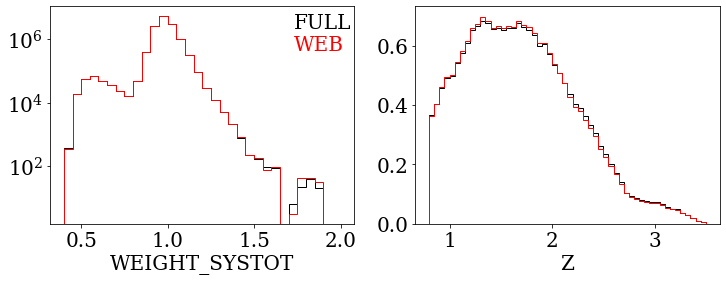

RA             , [109.71285957 173.8685974  263.2359112 ] [109.70737393 174.42142956 263.22565429]
DEC            , [16.00019367 41.93204505 59.99998516] [16.00001332 41.35794013 59.99999868]
Z              , [0.80003996 1.65853832 3.49776889] [0.80001524 1.63179164 3.49776889]
WEIGHT_FKP     , [0.88490545 0.90491525 1.        ] [0.88490545 0.90412735 1.        ]
WEIGHT_SYSTOT  , [1.00000002 1.03195456 1.87321573] [0.41106581 0.95952433 0.99999998]
WEIGHT_CP      , [1. 1. 4.] [1. 1. 4.]
WEIGHT_NOZ     , [1.         1.04267974 1.09279896] [1.         1.04295841 1.09336497]
NZ             , [0.00000000e+00 1.75126429e-05 2.16773725e-05] [0.00000000e+00 1.76731470e-05 2.16773725e-05]


In [17]:
test_cats('NGC', passfix='ran')

# Q1: any different columns?
# Z and Weight_Systot are different

# Q2: what is the distribution of these two?
# the full catalogs do not have randoms with systot > 1

# Q3: is anything specifically different for wsys > 1 vs wsys < 1? nothing

Z has 842
WEIGHT_SYSTOT has 620
wsys: [0.5037037  0.98697068 1.        ]
z:    [0.80001524 1.64095605 3.49776889]
wsys: [0.41106581 0.97932495 1.87321573]
z:    [0.80001524 1.64039987 3.49776889]


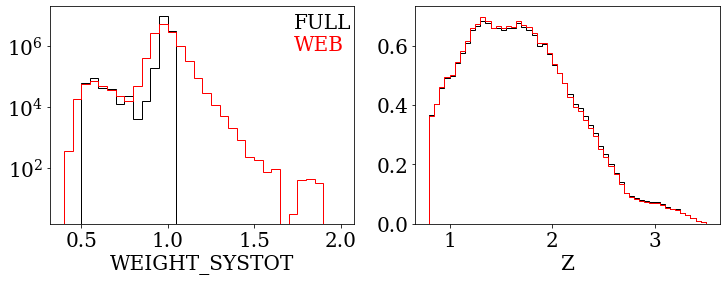

RA             , [109.71285957 173.8685974  263.2359112 ] [109.70737393 174.42142956 263.22565429]
DEC            , [16.00019367 41.93204505 59.99998516] [16.00001332 41.35794013 59.99999868]
Z              , [0.80003996 1.65853832 3.49776889] [0.80001524 1.63179164 3.49776889]
WEIGHT_FKP     , [0.88490545 0.90491525 1.        ] [0.88490545 0.90412735 1.        ]
WEIGHT_SYSTOT  , [1.00000002 1.03195456 1.87321573] [0.41106581 0.95952433 0.99999998]
WEIGHT_CP      , [1. 1. 4.] [1. 1. 4.]
WEIGHT_NOZ     , [1.         1.04267974 1.09279896] [1.         1.04295841 1.09336497]
NZ             , [0.00000000e+00 1.75126429e-05 2.16773725e-05] [0.00000000e+00 1.76731470e-05 2.16773725e-05]


In [18]:
test_cats('NGC', tag='_old', passfix='ran')

# Q1: any different columns?
# Z and Weight_Systot are different

# Q2: what is the distribution of these two?
# the full catalogs do not have randoms with systot > 1

# Q3: is anything specifically different for wsys > 1 vs wsys < 1? nothing

wsys: [0.81071312 0.9940144  1.87321573]
z:    [0.80001524 1.640757   3.49776889]
wsys: [0.81071312 0.9940144  1.87321573]
z:    [0.80001524 1.640757   3.49776889]


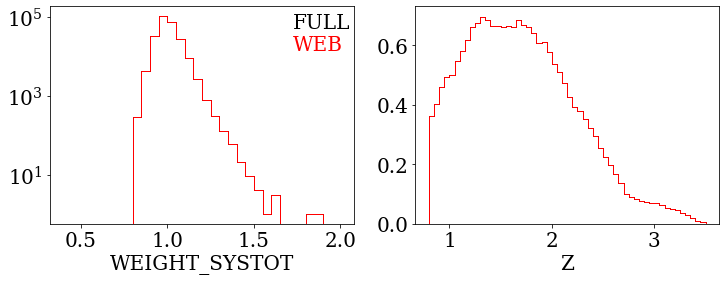

RA             , [109.77126007 149.11719315 263.08140021] [112.37291279 194.75226293 263.08618461]
DEC            , [16.00152882 41.45036254 59.99883987] [16.00999271 41.96312075 59.99831275]
Z              , [0.80003996 1.64052113 3.49776889] [0.80001524 1.64082763 3.49687245]
WEIGHT_FKP     , [0.88490545 0.90448937 1.        ] [0.88490545 0.90448937 1.        ]
WEIGHT_SYSTOT  , [1.00000044 1.0329742  1.87321573] [0.81071312 0.96905909 0.99999798]
WEIGHT_CP      , [1. 1. 4.] [1. 1. 3.]
WEIGHT_NOZ     , [1.         1.04296042 1.09279896] [1.         1.04280541 1.09336497]
NZ             , [0.00000000e+00 1.75993645e-05 2.16773725e-05] [0.00000000e+00 1.75993645e-05 2.16773725e-05]
QSO_ID         , [168690.  522061.5 703519. ] [168697. 528923. 703520.]


In [12]:
# data is fine
test_cats('NGC', passfix='dat')

Z has 910
WEIGHT_SYSTOT has 4782464
wsys: [2.10869721e-31 9.73945425e-01 1.87484365e+00]
z:    [0.80004008 1.64953743 3.49746618]
wsys: [2.14388728e-31 9.73950423e-01 1.87484365e+00]
z:    [0.80004008 1.64948299 3.49746618]


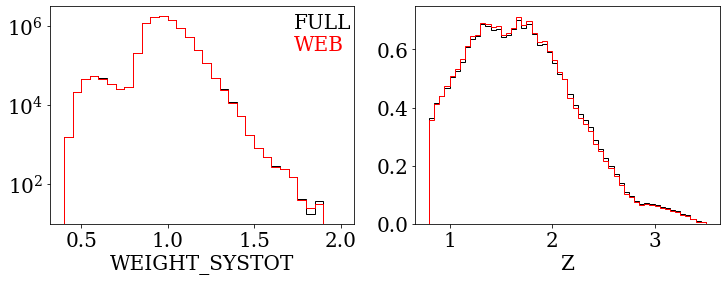

RA             , [3.32011922e-06 3.01432895e+01 3.59999978e+02] [9.73279057e-06 3.01576183e+01 3.59999973e+02]
DEC            , [-6.99997441 10.67871666 36.24952172] [-6.9990795  10.12708648 36.24898019]
Z              , [0.80007312 1.65911125 3.49746618] [0.80004008 1.64331109 3.49746618]
WEIGHT_FKP     , [0.89360387 0.9131721  1.        ] [0.89360387 0.91252504 1.        ]
WEIGHT_SYSTOT  , [1.0000001  1.06046562 1.87484365] [2.14388728e-31 9.27382771e-01 9.99999982e-01]
WEIGHT_CP      , [1. 1. 4.] [1. 1. 4.]
WEIGHT_NOZ     , [1.         1.05459454 1.08974705] [1.         1.05449578 1.08983046]
NZ             , [0.00000000e+00 1.58473039e-05 1.98440143e-05] [0.00000000e+00 1.59767227e-05 1.98440143e-05]


In [19]:
# how about SGC
test_cats('SGC', passfix='ran')

wsys: [3.99542629e-31 9.89874530e-01 1.87484365e+00]
z:    [0.80004008 1.64932714 3.49746618]
wsys: [3.99542629e-31 9.89874530e-01 1.87484365e+00]
z:    [0.80004008 1.64932714 3.49746618]


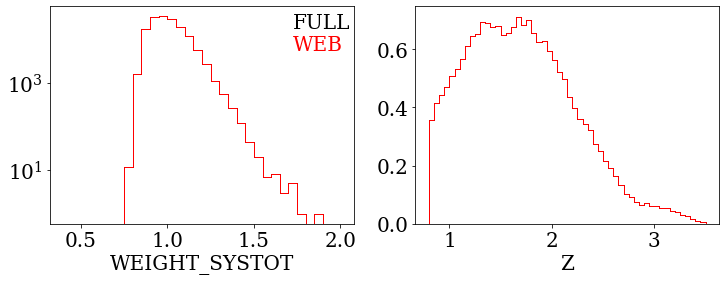

RA             , [6.29498925e-04 2.98896853e+01 3.59999759e+02] [1.41450863e-03 3.07691895e+01 3.59999954e+02]
DEC            , [-6.99781694 20.23590706 36.20762965] [-6.01700396  2.87857087 36.24332806]
Z              , [0.80007312 1.65392382 3.49746618] [0.80004008 1.6452632  3.49649345]
WEIGHT_FKP     , [0.89360387 0.91252504 1.        ] [0.89360387 0.91252504 1.        ]
WEIGHT_SYSTOT  , [1.0000009  1.06300373 1.87484365] [3.99542629e-31 9.36851139e-01 9.99998245e-01]
WEIGHT_CP      , [1. 1. 4.] [1. 1. 4.]
WEIGHT_NOZ     , [1.         1.05459723 1.08974705] [1.         1.0544656  1.08983046]
NZ             , [0.00000000e+00 1.59767227e-05 1.98440143e-05] [0.00000000e+00 1.59767227e-05 1.98440143e-05]
QSO_ID         , [2.580000e+02 2.131885e+05 4.514980e+05] [  4116.  73742. 451513.]


In [14]:
# How about SGC data?
test_cats('SGC', passfix='dat')

Z has 910
WEIGHT_SYSTOT has 5900976
wsys: [0.39464353 0.97170398 1.79790743]
z:    [0.80004008 1.64953743 3.49746618]
wsys: [2.14388728e-31 9.73950423e-01 1.87484365e+00]
z:    [0.80004008 1.64948299 3.49746618]


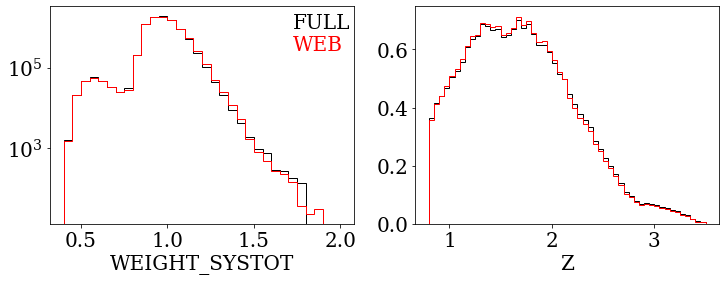

RA             , [3.32011922e-06 3.01432895e+01 3.59999978e+02] [9.73279057e-06 3.01576183e+01 3.59999973e+02]
DEC            , [-6.99997441 10.67871666 36.24952172] [-6.9990795  10.12708648 36.24898019]
Z              , [0.80007312 1.65911125 3.49746618] [0.80004008 1.64331109 3.49746618]
WEIGHT_FKP     , [0.89360387 0.9131721  1.        ] [0.89360387 0.91252504 1.        ]
WEIGHT_SYSTOT  , [1.0000001  1.06046562 1.87484365] [2.14388728e-31 9.27382771e-01 9.99999982e-01]
WEIGHT_CP      , [1. 1. 4.] [1. 1. 4.]
WEIGHT_NOZ     , [1.         1.05459454 1.08974705] [1.         1.05449578 1.08983046]
NZ             , [0.00000000e+00 1.58473039e-05 1.98440143e-05] [0.00000000e+00 1.59767227e-05 1.98440143e-05]


In [15]:
# How about SGC? but with a NN-based random
test_cats('SGC', '_known_allhigh')

WEIGHT_SYSTOT has 108721
wsys: [0.75303486 0.98738516 1.79790743]
z:    [0.80004008 1.64932714 3.49746618]
wsys: [3.99542629e-31 9.89874530e-01 1.87484365e+00]
z:    [0.80004008 1.64932714 3.49746618]


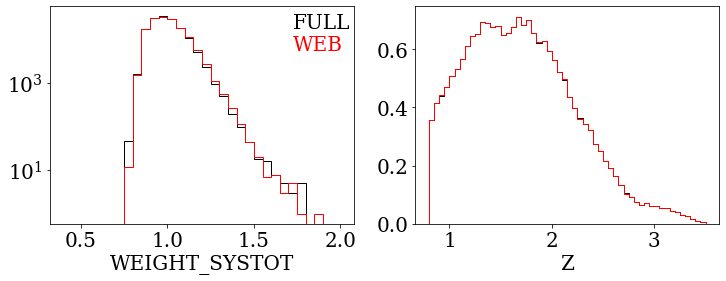

RA             , [6.29498925e-04 2.98896853e+01 3.59999759e+02] [1.41450863e-03 3.07691895e+01 3.59999954e+02]
DEC            , [-6.99781694 20.23590706 36.20762965] [-6.01700396  2.87857087 36.24332806]
Z              , [0.80007312 1.65392382 3.49746618] [0.80004008 1.6452632  3.49649345]
WEIGHT_FKP     , [0.89360387 0.91252504 1.        ] [0.89360387 0.91252504 1.        ]
WEIGHT_SYSTOT  , [1.0000009  1.06300373 1.87484365] [3.99542629e-31 9.36851139e-01 9.99998245e-01]
WEIGHT_CP      , [1. 1. 4.] [1. 1. 4.]
WEIGHT_NOZ     , [1.         1.05459723 1.08974705] [1.         1.0544656  1.08983046]
NZ             , [0.00000000e+00 1.59767227e-05 1.98440143e-05] [0.00000000e+00 1.59767227e-05 1.98440143e-05]
QSO_ID         , [2.580000e+02 2.131885e+05 4.514980e+05] [  4116.  73742. 451513.]


In [16]:
# How about SGC? but with a NN-based random
test_cats('SGC', '_known_allhigh', passfix='dat')

In [7]:
import pandas as pd

In [4]:
import sys
sys.path.insert(0, '/home/mehdi/github/LSSutils')
from LSSutils.catalogs import combinefits as cf

camb is not installed!


In [3]:
LSS.setup_logging("info")

In [9]:
templates = pd.read_hdf('/home/mehdi/data/eboss/sysmaps/SDSS_WISE_HI_imageprop_nside512.h5',key='templates')

In [10]:
templates.head()

,nran,sky_g,sky_r,sky_i,sky_z,airmass,ebv,depth_g,depth_r,depth_i,...,psf_r,psf_i,psf_z,w1_med,w1_covmed,w1_moon,star_density,loghi,run,depth_g_minus_ebv
0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,2.321053,53.861678,0.0,0.0,20.802680,NaN,NaN
1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,2.247458,56.505509,0.0,0.0,20.787574,NaN,NaN
2,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,2.247467,56.505200,0.0,0.0,20.776386,NaN,NaN
3,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,2.321044,53.861987,0.0,0.0,20.788406,NaN,NaN
4,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,2.324270,53.746094,0.0,0.0,20.805544,NaN,NaN


In [6]:
qso    = cf.EbossCatalog('/home/mehdi/data/eboss/v7_2/eBOSS_QSO_full_NGC_v7_2.dat.fits', kind='galaxy')
random = cf.EbossCatalog('/home/mehdi/data/eboss/v7_2/eBOSS_QSO_full_NGC_v7_2.ran.fits', kind='random')
qsohighz    = cf.EbossCatalog('/home/mehdi/data/eboss/v7_2/eBOSS_QSO_full_NGC_v7_2.dat.fits', kind='galaxy', zmin=2.2, zmax=3.5)
randomhighz = cf.EbossCatalog('/home/mehdi/data/eboss/v7_2/eBOSS_QSO_full_NGC_v7_2.ran.fits', kind='random', zmin=2.2, zmax=3.5)

[ 000271.70 ]   0: 02-13 21:15  EbossCatalog    INFO     compmin : 0.5
[ 000271.70 ]   0: 02-13 21:15  EbossCatalog    INFO     zmin:0.8, zmax:2.2
[ 000271.80 ]   0: 02-13 21:15  EbossCatalog    INFO     218209 galaxies pass the cuts
[ 000271.80 ]   0: 02-13 21:15  EbossCatalog    INFO     % of galaxies after cut 0.54
[ 000273.18 ]   0: 02-13 21:15  EbossCatalog    INFO     compmin : 0.5
[ 000273.18 ]   0: 02-13 21:15  EbossCatalog    INFO     zmin:0.8, zmax:2.2
[ 000274.14 ]   0: 02-13 21:15  EbossCatalog    INFO     11099858 randoms pass the cuts
[ 000274.17 ]   0: 02-13 21:15  EbossCatalog    INFO     % of randoms after cut 0.64
[ 000278.19 ]   0: 02-13 21:15  EbossCatalog    INFO     compmin : 0.5
[ 000278.19 ]   0: 02-13 21:15  EbossCatalog    INFO     zmin:2.2, zmax:3.5
[ 000278.71 ]   0: 02-13 21:15  EbossCatalog    INFO     46679 galaxies pass the cuts
[ 000278.72 ]   0: 02-13 21:15  EbossCatalog    INFO     % of galaxies after cut 0.12
[ 000279.92 ]   0: 02-13 21:15  EbossCata

In [14]:
usemaps = ['star_density', 'ebv', 'psf_i', 'sky_i', 'depth_g_minus_ebv', 'airmass']

In [15]:
from LSSutils.stats.nnbar import NNBAR

In [17]:
from LSSutils.utils import hpixsum

In [22]:
import matplotlib.pyplot as plt
import healpy as hp

In [29]:
LSS.setup_logging("warning")

In [42]:
nside=512
zcuts={'low':[0.8,1.5],
      'high':[1.5,2.2],
      'all':[0.8,2.2],
      'zhigh':[2.2,3.5]}

results= {}



for zcut in zcuts:
    
    if zcut=='zhigh':
        sample=qsohighz
        ransom=randomhighz
    else:
        sample=qso
        ransom=random
        
    
    sample.cutz(zcuts[zcut])
    weight = sample.cdata['WEIGHT_CP']*sample.cdata['WEIGHT_FKP']*sample.cdata['WEIGHT_NOZ']        
    sample.hpmap= hpixsum(nside, sample.cdata['RA'], sample.cdata['DEC'], value=weight*sample.cdata['WEIGHT_SYSTOT'])
    sample.hpmap2 = hpixsum(nside, sample.cdata['RA'], sample.cdata['DEC'], value=weight)

    weight = ransom.data['WEIGHT_CP']*ransom.data['WEIGHT_FKP']*ransom.data['WEIGHT_NOZ']*ransom.data['WEIGHT_SYSTOT']      
    ransom.hpmap = hpixsum(nside, ransom.data['RA'], ransom.data['DEC'], value=weight)
    
    mask  = ransom.hpmap > 0
    
    for mapi in usemaps:
        
        print(zcut, mapi)
        
        sysmap = templates[mapi].values
        
        nnbar = NNBAR(sample.hpmap,
                      ransom.hpmap, 
                      mask, 
                      sysmap, 
                      nbins=5, 
                      binning='equi-area')
        
        nnbar.run()
        results['-'.join((zcut, mapi, 'after'))]=nnbar.output
        
        
        nnbar = NNBAR(sample.hpmap2,
                      ransom.hpmap, 
                      mask, 
                      sysmap, 
                      nbins=5, 
                      binning='equi-area')
        
        nnbar.run()
        results['-'.join((zcut, mapi, 'before'))]=nnbar.output

low star_density
low ebv
low psf_i
low sky_i
low depth_g_minus_ebv
low airmass
high star_density
high ebv
high psf_i
high sky_i
high depth_g_minus_ebv
high airmass
all star_density
all ebv
all psf_i
all sky_i
all depth_g_minus_ebv
all airmass
zhigh star_density
zhigh ebv
zhigh psf_i
zhigh sky_i
zhigh depth_g_minus_ebv
zhigh airmass


In [33]:
results['low-star_density']

{'nnbar': array([0.99961654, 1.02554634, 1.02877456, 0.98501248, 0.96104728]),
 'area': array([2494.00558967, 2494.0279944 , 2494.04618155, 2494.01592255,
        2493.86701311]),
 'nnbar_err': array([0.00606755, 0.00485741, 0.0068035 , 0.0079944 , 0.00726452]),
 'bin_edges': array([  2.25,  15.25,  18.  ,  22.75,  33.  , 127.  ]),
 'attr': {'njack': 20,
  'nbar': 0.010401604220658386,
  'nside': 256,
  'npix2area': 0.0012695251307729102}}

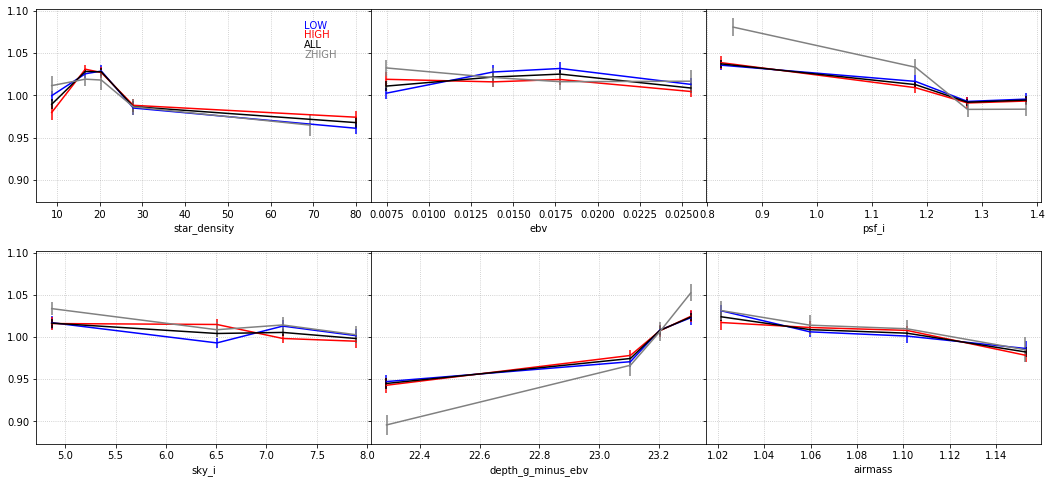

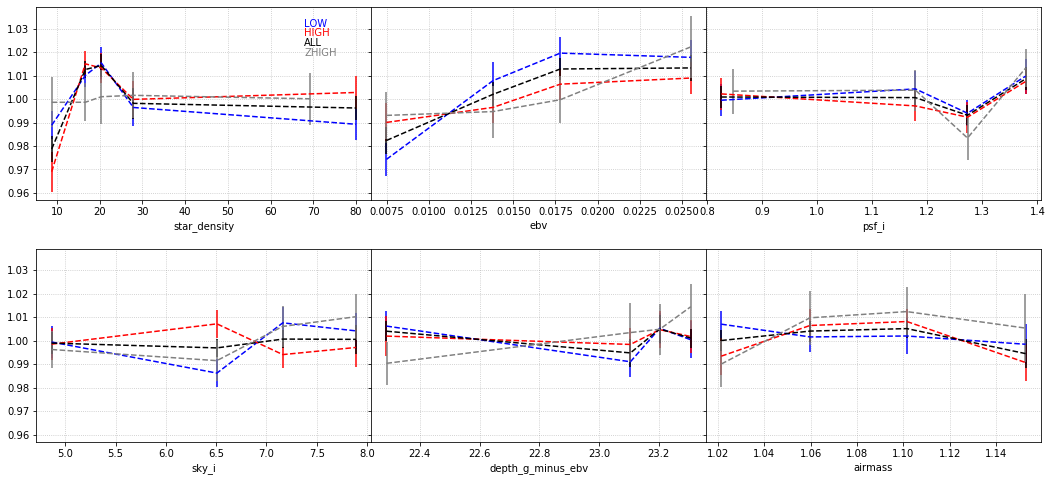

In [56]:
color = {'low':'b',
         'high':'r',
         'all':'k',
         'zhigh':'grey'}
ls = {'before':'-',
      'after':'--'}




for k, wght in enumerate(['before', 'after']):
    fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(18, 8),
                          sharey=True)
    fig.subplots_adjust(hspace=0.25, wspace=0.0)
    ax = ax.flatten()

    
    for j,zcut in enumerate(zcuts):
        for i,mapi in enumerate(usemaps):            
            myr=results['-'.join((zcut, mapi, wght))]
            x    = myr['bin_edges']
            xmid = 0.5*(x[1:]+x[:-1])
            y  = myr['nnbar']
            ye = myr['nnbar_err']
#             if wght=='after':ye=0
            ax[i].errorbar(xmid, y, ye, color=color[zcut], ls=ls[wght])
            
            if i==0:
                
                ax[0].text(0.8, 0.9-j*0.05, zcut.upper(), color=color[zcut], transform=ax[0].transAxes)
            if j==0:
                ax[i].set(xlabel=mapi)
                ax[i].grid(True, ls=':', color='grey', alpha=0.5)
plt.show()

In [59]:
id(qso), id(qsohighz)

(139694903967376, 139694902803216)

In [60]:
id?

In [71]:
a = [2, 1]
b = [5, 1]
print(a, b)
print(id(a), id(b))
c = a
c.append(3)
print(a, b, c)
print(id(a), id(b), id(c))

c = b
c.append(3)
print(a, b, c)
print(id(a), id(b), id(c))

[2, 1] [5, 1]
139693850964128 139693849252080
[2, 1, 3] [5, 1] [2, 1, 3]
139693850964128 139693849252080 139693850964128
[2, 1, 3] [5, 1, 3] [5, 1, 3]
139693850964128 139693849252080 139693849252080


In [95]:
!ls /home/mehdi/data/eboss/v7_2/0.1/results/NGC_*_512/regression/nn_plain/nn-weights.hp512.fits

/home/mehdi/data/eboss/v7_2/0.1/results/NGC_all_512/regression/nn_plain/nn-weights.hp512.fits
/home/mehdi/data/eboss/v7_2/0.1/results/NGC_high_512/regression/nn_plain/nn-weights.hp512.fits
/home/mehdi/data/eboss/v7_2/0.1/results/NGC_low_512/regression/nn_plain/nn-weights.hp512.fits
/home/mehdi/data/eboss/v7_2/0.1/results/NGC_zhigh_512/regression/nn_plain/nn-weights.hp512.fits


In [96]:
nnmap = lambda x:f'/home/mehdi/data/eboss/v7_2/0.1/results/NGC_{x}_512/regression/nn_plain/nn-weights.hp512.fits'

In [97]:
import numpy as np

In [98]:
nside=512
zcuts={'low':[0.8,1.5],
      'high':[1.5,2.2],
      'all':[0.8,2.2],
      'zhigh':[2.2,3.5]}


for zcut in zcuts:
    
    if zcut=='zhigh':
        sample=qsohighz
        ransom=randomhighz
    else:
        sample=qso
        ransom=random
        
    
    sample.cutz(zcuts[zcut])
    sample.tohp(nside)
    
    ransom.tohp(nside)
        
    mask  = ransom.hpmap > 0
    
    weight = hp.read_map(nnmap(zcut), verbose=False)
    nan = np.isnan(weight)
    weight[nan] = 1.0
    
    for mapi in usemaps:
        
        print(zcut, mapi)
        
        sysmap = templates[mapi].values
        
        nnbar = NNBAR(sample.hpmap,
                      ransom.hpmap, 
                      mask, 
                      sysmap, 
                      selection=weight,
                      nbins=5, 
                      binning='equi-area')
        
        nnbar.run()
        results['-'.join((zcut, mapi, 'afternnp'))]=nnbar.output

/home/mehdi/miniconda3/envs/py3p6/lib/python3.7/site-packages/healpy/pixelfunc.py:345: RuntimeWarning: invalid value encountered in less_equal
  return np.absolute(m - badval) <= atol + rtol * np.absolute(badval)


low star_density
low ebv
low psf_i
low sky_i
low depth_g_minus_ebv
low airmass
high star_density
high ebv
high psf_i
high sky_i
high depth_g_minus_ebv
high airmass
all star_density
all ebv
all psf_i
all sky_i
all depth_g_minus_ebv
all airmass
zhigh star_density
zhigh ebv
zhigh psf_i
zhigh sky_i
zhigh depth_g_minus_ebv
zhigh airmass


In [92]:
import matplotlib.backends.backend_pdf

In [99]:
pdf = matplotlib.backends.backend_pdf.PdfPages("nnbar_v7_2.pdf")

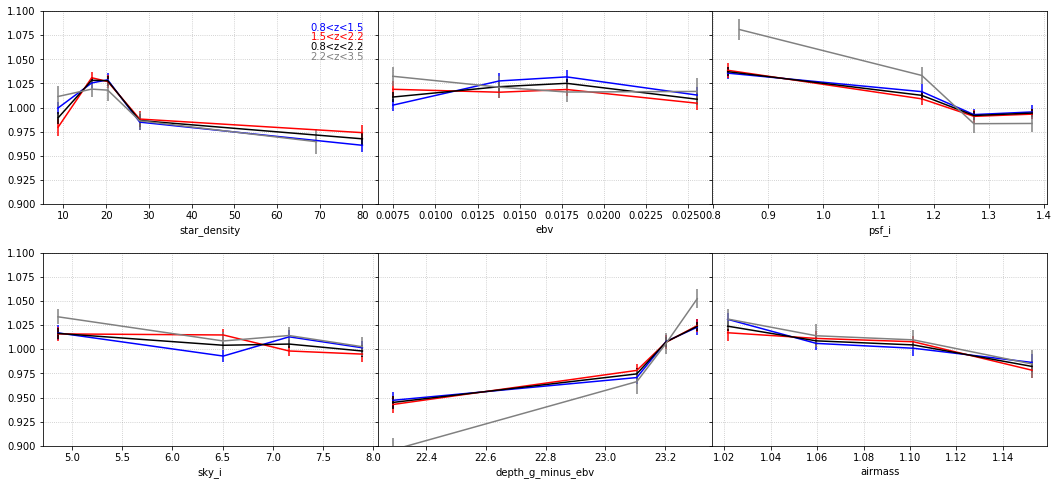

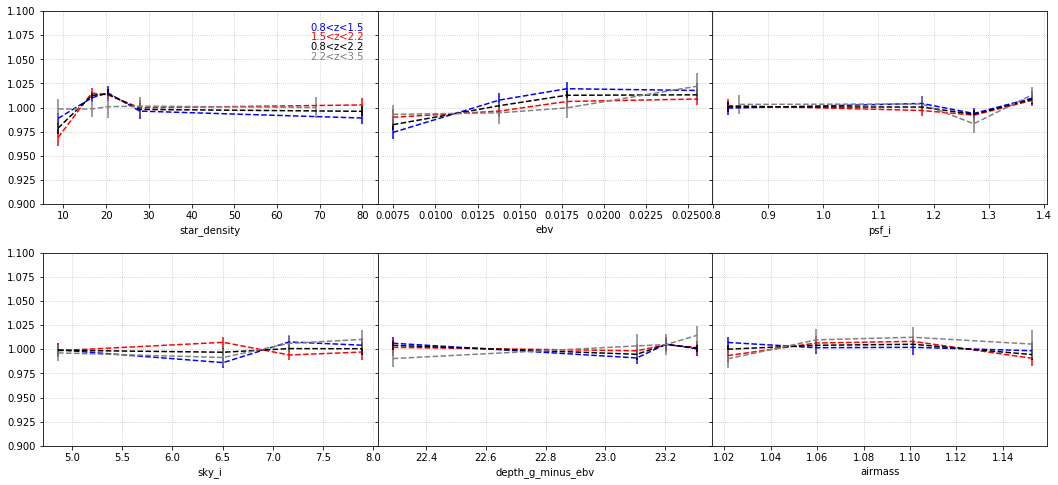

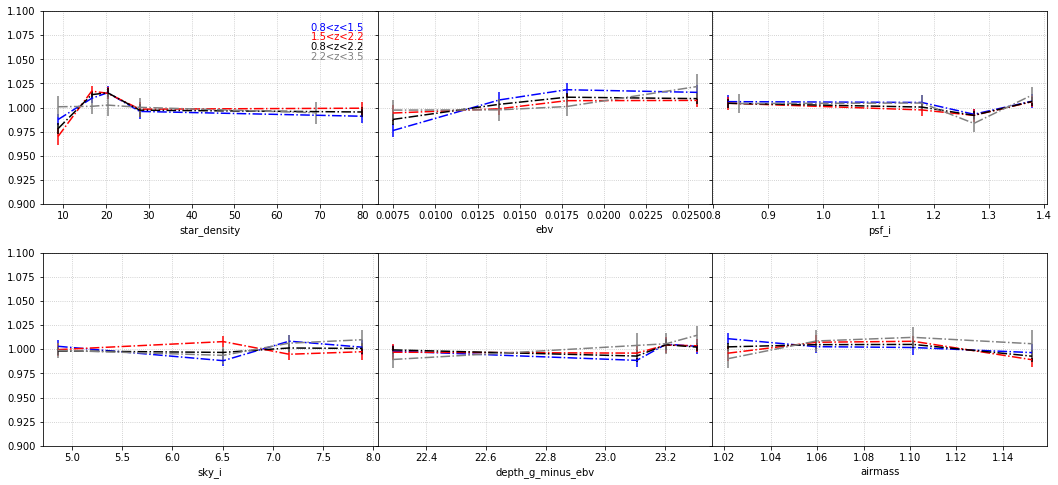

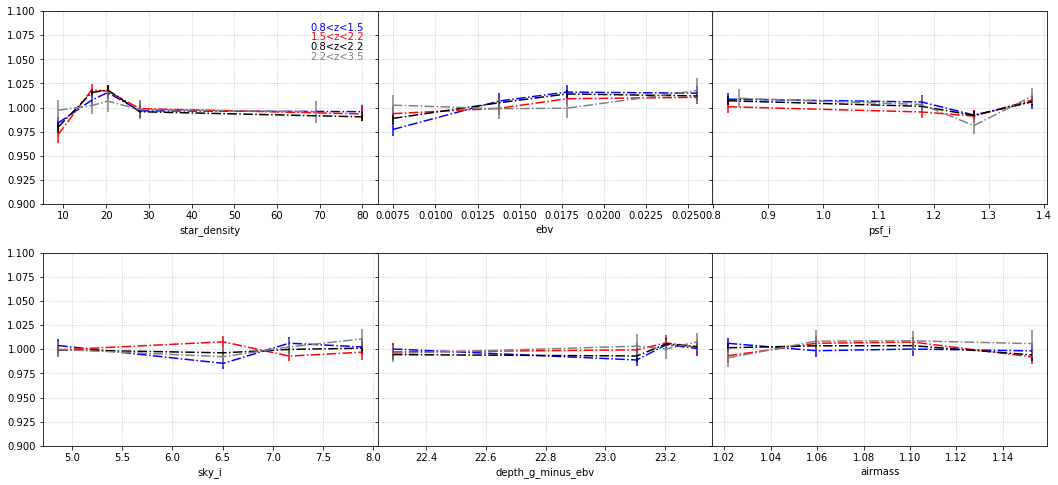

In [100]:
color = {'low':'b',
         'high':'r',
         'all':'k',
         'zhigh':'grey'}

ls = {'before':'-',
      'after':'--',
      'afternn':'-.',
      'afternnp':'-.'}

labels = {'low':'0.8<z<1.5',
         'high':'1.5<z<2.2',
         'all':'0.8<z<2.2',
         'zhigh':'2.2<z<3.5'}


for k, wght in enumerate(['before', 'after', 'afternn', 'afternnp']):
    fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(18, 8),
                          sharey=True)
    fig.subplots_adjust(hspace=0.25, wspace=0.0)
    ax = ax.flatten()

    
    for j,zcut in enumerate(zcuts):
        for i,mapi in enumerate(usemaps):            
            myr=results['-'.join((zcut, mapi, wght))]
            x    = myr['bin_edges']
            xmid = 0.5*(x[1:]+x[:-1])
            y  = myr['nnbar']
            ye = myr['nnbar_err']
#             if wght=='after':ye=0
            ax[i].errorbar(xmid, y, ye, color=color[zcut], ls=ls[wght])
            
            if i==0:
                
                ax[0].text(0.8, 0.9-j*0.05, labels[zcut], color=color[zcut], transform=ax[0].transAxes)
            if j==0:
                ax[i].set(xlabel=mapi, ylim=(0.9,1.1))
                ax[i].grid(True, ls=':', color='grey', alpha=0.5)
    pdf.savefig((k+1), bbox_inches='tight')
pdf.close()